# Linear Regression Netural Network

In [68]:
import math
import time
import numpy as np
import torch
import random
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt

In [69]:
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

## Vector acceleration

In [70]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]

print(a, b, c)
f'{timer.stop():.5f} sec'


tensor([1., 1., 1.,  ..., 1., 1., 1.]) tensor([1., 1., 1.,  ..., 1., 1., 1.]) tensor([2., 2., 2.,  ..., 2., 2., 2.])


'0.12300 sec'

In [71]:
timer.start()
d = a + b
print(a,b,d)
f'{timer.stop():.5f} sec'


tensor([1., 1., 1.,  ..., 1., 1., 1.]) tensor([1., 1., 1.,  ..., 1., 1., 1.]) tensor([2., 2., 2.,  ..., 2., 2., 2.])


'0.00200 sec'

## normal distribution

In [72]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)


In [73]:
def use_svg_display(): #@save
    """svg"""
    backend_inline.set_matplotlib_formats('svg')

## figure size
def set_figsize(figsize=(3.5, 2.5)): #@save
    """matplotlib figuresize"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

## get the figure axis
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set matplotlib Axis"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点图形"""
    if legend is None:
        legend = []
    
    set_figsize(figsize)
    axes = axes if axes else plt.gca()
    
    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    
    if len(X) != len(Y):
        X = X * len(Y)
        axes.cla()
    
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    
    return axes

def has_one_axis(X):
    """判断数据是否有一个轴"""
    return hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list) and not hasattr(X[0], "__len__")
    

<Axes: xlabel='x', ylabel='p(x)'>

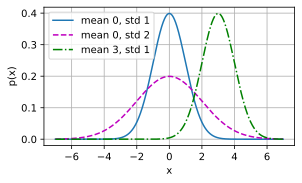

In [74]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)
# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x', ylabel='p(x)', figsize=(4.5, 2.5), legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])


##  LRNN Start

In [75]:
# dataset
def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [76]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [77]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.2798,  0.3233]) 
label: tensor([2.5467])


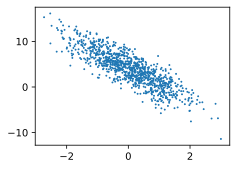

In [78]:
set_figsize()
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);


In [79]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # Some Sample are random
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
        indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [80]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.0918,  1.4552],
        [-0.5215, -0.0553],
        [-0.4177, -1.3515],
        [ 0.0754, -1.9068],
        [ 0.1854, -0.5110],
        [ 0.5826, -0.0711],
        [ 0.6423, -0.9414],
        [-1.4748, -0.1032],
        [ 1.0387,  0.8746],
        [ 0.9070, -0.3974]]) 
 tensor([[-0.9544],
        [ 3.3428],
        [ 7.9658],
        [10.8301],
        [ 6.3154],
        [ 5.6105],
        [ 8.6870],
        [ 1.6050],
        [ 3.3134],
        [ 7.3465]])


### Initlize Model 

In [81]:
# mean = 0 , std = 0.01
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0009],
         [-0.0070]], requires_grad=True),
 tensor([0.], requires_grad=True))

### def Model 

In [82]:
def linreg(X, w, b): #@save
    """LR"""
    return torch.matmul(X, w) + b

### def squard_loss

In [83]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### def and improve aglorism 

In [84]:
def sgd(params, lr, batch_size): #@save
    """small batch_size grident deduction"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


### Train

In [85]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.058892
epoch 2, loss 0.000285
epoch 3, loss 0.000054


In [86]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0005, -0.0012], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0008], grad_fn=<RsubBackward1>)


## Softmax

## 1.5 Graphic Dataset

In [87]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from matplotlib import pyplot as plt
# from collections.abc import Mapping

def use_svg_display(): #@save
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

In [88]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

In [89]:
print(mnist_train, mnist_test)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [90]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [91]:
def get_fashion_mnist_labels(labels): #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [92]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            if titles:
                ax.set_title(titles[i])
    return axes

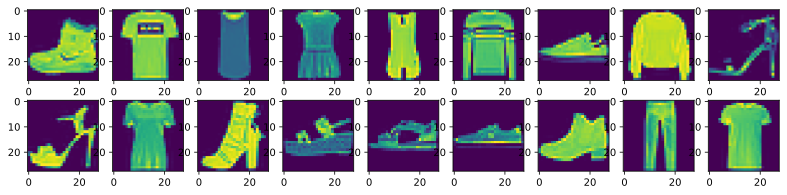

In [93]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));


In [94]:
batch_size = 256
def get_dataloader_workers(): #@save
    """使用4个进程来读取数据"""
    return 4
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

In [95]:
# dataset read time
timer = Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'6.23 sec'

In [96]:
## combine allcomponent 
def load_data_fashion_mnist(batch_size, resize=batch_size): #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
        trans = transforms.Compose(trans)
        mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
        mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
        num_workers=get_dataloader_workers()),
        data.DataLoader(mnist_test, batch_size, shuffle=False,
        num_workers=get_dataloader_workers()))


In [97]:
# resize to change the size of graphic
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## Softmax Regression

In [98]:
import torch
from IPython import display


batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)


### Init Softmax

In [99]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)
W,b

(tensor([[ 1.6698e-02, -1.3184e-02,  7.0269e-03,  ...,  1.6094e-02,
           7.5936e-03,  1.8236e-03],
         [ 4.8561e-04,  9.0997e-03, -1.9889e-03,  ..., -4.8401e-03,
          -3.3379e-03,  1.2802e-02],
         [-3.6955e-03, -7.8966e-03,  7.5894e-03,  ..., -8.2784e-03,
          -3.2193e-03,  1.6087e-02],
         ...,
         [-8.1452e-05, -2.6394e-03, -1.0615e-03,  ..., -8.2654e-03,
           9.7628e-03,  1.0494e-02],
         [-9.4721e-03,  4.8071e-03,  1.8162e-02,  ..., -9.0130e-03,
          -1.7954e-02, -1.3601e-02],
         [-1.8906e-02, -1.7367e-02, -8.9576e-03,  ..., -1.0438e-02,
          -4.2198e-03,  4.4703e-03]], requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

### Define Softmax operation

In [100]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)


(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [101]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这里应用了广播机制

X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)


(tensor([[0.1159, 0.0495, 0.5696, 0.0533, 0.2117],
         [0.1678, 0.1644, 0.1089, 0.3213, 0.2375]]),
 tensor([1.0000, 1.0000]))

### Define models

In [102]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### Define Loss Function

In [103]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [104]:
#這段程式碼定義了交叉熵損失函式，它通常用於衡量模型預測的概率分佈與實際標籤之間的差異
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### Define Loss Function

In [105]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [106]:
accuracy(y_hat, y) / len(y)

0.5

In [107]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [108]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [114]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [110]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [111]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [112]:
lr = 0.1

def updater(batch_size):
    return sgd([W, b], lr, batch_size)


AttributeError: 'function' object has no attribute 'train'

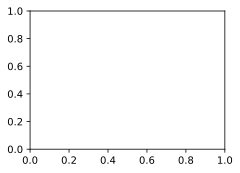

In [113]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## softmax Easy

In [ ]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状

import torch
from torch import nn

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

trainer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)